# Advanced Methods in Natural Language Processing - Final Project
## Predicting Movie Genres from Movie Descriptions
### Nikita Baklazhenko, Miguel Conner, David Vallmanya, Dominik Wielath

For our final project, we analyzed a data set of movie descriptions from the Internet Movie Database (IMDb) posted on Kaggle. The data set contains, besides the movie description also, its title, the year it was published, and its genre. Our project aims to predict the genre of a movie based on its description. In particular, we compare different methods regarding their predictive power, strengths, and limitations. 



In [90]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import re 


from collections import Counter
from helper_functions import *

# Natural language Toolkit
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.stem import SnowballStemmer                                   # Porter's II Stemmer
from nltk import word_tokenize                                          # Document tokenizer
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer


from sklearn import metrics
from sklearn.metrics import f1_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import GRU, Dense, Embedding, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import torch.backends.cudnn as cudnn
cudnn.benchmark = True
cudnn.max_workspace_size = 1 << 30
import torch
import numpy as np
from transformers import BertTokenizer
from torch import nn
from transformers import BertModel
from torch.optim import Adam
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
import torch
import numpy as np
import pandas as pd
from transformers import BertTokenizer
from torch import nn
from transformers import BertModel
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nikit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nikit\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Load Data

In [91]:
# Set directory
directory_david = '/run/media/david-vp/davidvp-files/DSMMaster/advanced-nlp/final-proj/Genre Classification Dataset/'
directory_david2 = '/run/media/davovapo/hdd1-dvp/DSMMaster/advanced-nlp/Advanced_NLP_Project/Genre Classification Dataset/'
directory_miguel ='/Users/Miguel/Desktop/BSE/Term2/Advanced NLP/Advanced_NLP_Project/Genre Classification Dataset/'
directory_dominik = ''
directory_nikita = 'Genre Classification Dataset'
directory = directory_nikita

In [92]:
# Load training data set
filename ="train_data.txt"

df_train = pd.read_csv(os.path.join(directory, filename), delimiter=":::", encoding='utf-8', header=None)

df_train.drop(columns=df_train.columns[0], axis=1, inplace=True)
df_train.columns =['title', 'genre', 'description']
df_train['genre']=df_train['genre'].apply(lambda x: x.strip())

df_train.head()

C:\Users\nikit\AppData\Local\Temp\ipykernel_15060\521048698.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_train = pd.read_csv(os.path.join(directory, filename), delimiter=":::", encoding='utf-8', header=None)


,title,genre,description
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [93]:
# Load testing data set
filename = "test_data_solution.txt"
df_test = pd.read_csv(os.path.join(directory, filename), delimiter=":::", encoding='utf-8', header=None)

df_test.drop(columns=df_test.columns[0], axis=1, inplace=True)
df_test.columns =['title', 'genre', 'description']
df_test['genre']=df_test['genre'].apply(lambda x: x.strip())

df_test.head()

C:\Users\nikit\AppData\Local\Temp\ipykernel_15060\2294710050.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_test = pd.read_csv(os.path.join(directory, filename), delimiter=":::", encoding='utf-8', header=None)


,title,genre,description
0,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar..."
1,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch..."
2,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family ...
3,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with hi..."
4,Er nu zhai (1955),drama,Before he was known internationally as a mart...


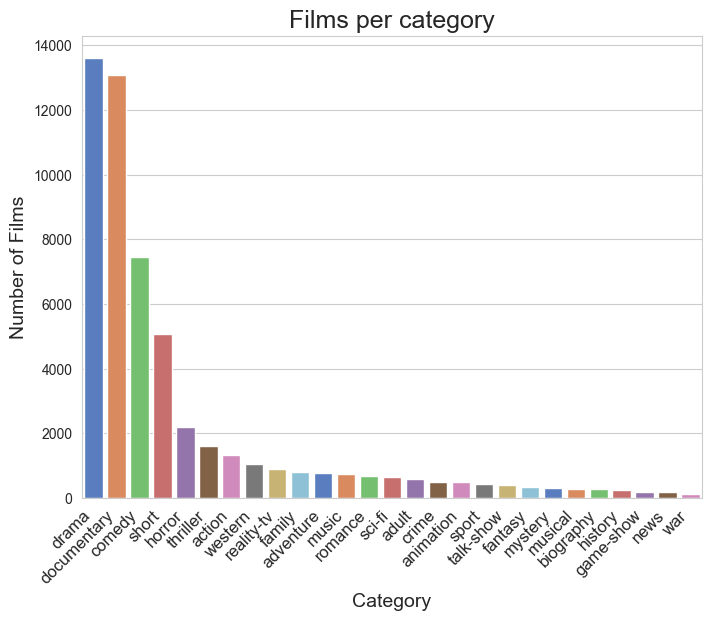

In [94]:
# Create a bar plot of the genre counts
sns.set_style("whitegrid")
plt.figure(figsize=(8,6))
sns.barplot(x=df_train.genre.value_counts().index,
            y=df_train.genre.value_counts(),
            palette="muted")

# Customize the plot
plt.title("Films per category", fontsize=18)
plt.xlabel("Category", fontsize=14)
plt.ylabel("Number of Films", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)

# Show the plot
plt.show()

We can see that we have very large class imbalance. There are many movies in few categories while most categories only contain a small number of movies. As we expect our model's performance to correlate with the sample size for each category, we exclude categories with very few numbers of movies within our training set. Further, we exclude genres from which we expect that there might be larger variation in the topics discussed in the description. For example a short film could deal with topics similar to genres like horror or comedy. There is likely no clear pattern. Therefore, we also exclude these categories in our analysis. 

In [95]:
# Only keep some columns
list_labels = ["drama", "comedy", "horror", "thriller", "action", "western", "sci-fi"]

df_train = df_train[df_train["genre"].isin(list_labels)]
df_test = df_test[df_test["genre"].isin(list_labels)]

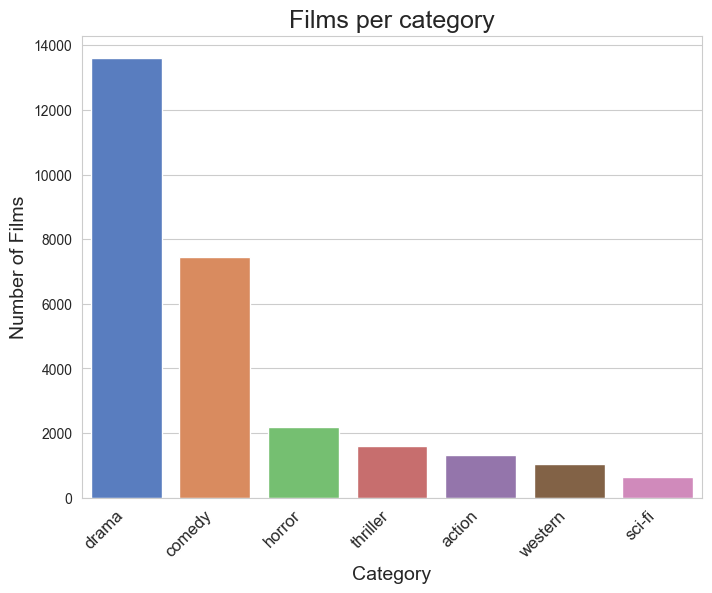

In [96]:
# Create a bar plot of the genre counts
sns.set_style("whitegrid")
plt.figure(figsize=(8,6))
sns.barplot(x=df_train.genre.value_counts().index,
            y=df_train.genre.value_counts(),
            palette="muted")

# Customize the plot
plt.title("Films per category", fontsize=18)
plt.xlabel("Category", fontsize=14)
plt.ylabel("Number of Films", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)

# Show the plot
plt.show()

# Preprocessing

## Extract the year from the title and save it as variable in the data frame

In [97]:
df_train["year"] = df_train["title"].apply(get_year)
df_test["year"] = df_test["title"].apply(get_year)

## Remove Stopwords

In [98]:
# Defining stopwords
# using predefined english stopwords
stop_words = set(stopwords.words('english'))

# including additional stopwords
my_stopwords = ['lol', 'people', 'expand',
                'really', 'deal','u', 'much', 'get', 'good', 'act', 'put', 'man', 'a', 'think', 'one',
                'say', 'like', 'go', 'do', 'head', 'yet', 'wall', 'guess', 'keep', 'oh', 'north', 'oil',
                'prize', 'involved', 'might', 'medium''among', 'might', 'make', 'do', 'may', 'year', 'give',
                'also', 'law', 'etc', 'wait', 'prove', 'mean', 'thing', 'rest', 'middle','rnr','u','fuck','make',
                'would', 'know', 'lot', 'see', 'president', 'done', 'even', 'many', 'ever', 'want', 'made',
                'got', 'going', 'need', 'view', 'something', 'lasting', 'still', 'way', 'every', 'anyone', 
                'first', 'look', 'medium', 'time', 'since', 'life', 'probably', 'anything', 'come', 
                'long', 'could', 'anything', 'donald', 'back', 'sure', 'last', 'nothing', 'rate', 'well',
                'left', 'le', 'someone', 'example', 'seen', 'day', 'said', 'world', 'making', 'far', 'care',
                'shit','america','issue','new', 'actually','never','whole','exposed','imapct','side','single']
stop_words.update(my_stopwords)

In [99]:
df_train['description_pp'] = df_train['description'].apply(remove_stopwords, args=(stop_words,))
df_test['description_pp'] = df_test['description'].apply(remove_stopwords, args=(stop_words,))

### Lemmatize

In [100]:
# Tokenize: Split the sentence into words
docs = df_train['description_pp']

lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

# Lemmatize list of words and join
lemmatized_output = [''.join([lemmatizer.lemmatize(w) for w in doc]) for doc in docs]
df_train['description_pp'] = lemmatized_output
df_train.head()

,title,genre,description,year,description_pp
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,2009,"Listening conversation doctor parents, 10-year..."
1,Cupid (1997),thriller,A brother and sister with a past incestuous r...,1997,brother sister past incestuous relationship cu...
3,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1915,"help unemployed father ends meet, Edith twin s..."
4,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,2007,film's title refers un-recovered bodies ground...
6,"""Pink Slip"" (2009)",comedy,In tough economic times Max and Joey have all...,2009,"tough economic times Max Joey run ideas until,..."


In [101]:
# Tokenize: Split the sentence into words
docs = df_test['description_pp']

lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

# Lemmatize list of words and join
lemmatized_output = [''.join([lemmatizer.lemmatize(w) for w in doc]) for doc in docs]
df_test['description_pp'] = lemmatized_output
df_test.head()

,title,genre,description,year,description_pp
0,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar...",1998,"L.R. Brane loves - car, apartment, job, especi..."
1,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch...",1977,"Spain, March 1964: Quico naughty child three b..."
3,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with hi...",2015,"father died, spoken brother 10 years serious c..."
4,Er nu zhai (1955),drama,Before he was known internationally as a mart...,1955,"known internationally martial arts superstar, ..."
5,Riddle Room (2016),horror,Emily Burns is being held captive in a room w...,2016,Emily Burns held captive room idea there. Dete...


# Baseline

## Random assignment based on frequency of genres in the training data

Choose randomly among the genres and use the share of the genres in the training data set as probability that a specific genre is assigned

In [102]:
genre_priors = df_train.genre.value_counts() / df_train.shape[0]
genre_priors = pd.DataFrame(data={"genre":genre_priors.index, "probability": genre_priors.values})
genre_priors = genre_priors.sort_values("genre")

In [103]:
# Predict genres for test data
prior_predictions = np.random.choice(genre_priors.genre.values, size = df_test.shape[0], p = genre_priors.probability.values)
df_test["prior_predictions"] = prior_predictions

In [104]:
# Evaluate prediction performance
true_labels = df_test["genre"]
f1 = f1_score(true_labels, prior_predictions, average="weighted")
recall = recall_score(true_labels, prior_predictions, average="weighted")

print("F1: ",f1)
print("Recall: ",recall)

F1:  0.325773348832418
Recall:  0.32581525642867404


## Dictionary based prediction

### Frequency (TF) dictionary

Creating an dictionary using the 50 most frequent words per category.

In [105]:
terms_by_genre = {}

# Iterrate over genres
for genre in df_train['genre'].unique():

    # Join descriptions of all movies for each genre
    genre_df = df_train[df_train['genre'] == genre]
    all_descriptions = ' '.join(genre_df['description_pp'])
    all_words = all_descriptions.split()
    word_counts = Counter(all_words)
    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    top_words = [word for word, count in sorted_words[:50]]
    terms_by_genre[genre] = top_words

In [106]:
df_test["frequency_prediction"] = dictionary_predictions(df_test, "description_pp", terms_by_genre, genre_priors)

Share of data which was labeled based on dictionary: 0.521
Share of data randomly labled using prior distribution: 0.479


In [107]:
true_labels = df_test["genre"]
f1 = f1_score(true_labels, df_test["frequency_prediction"], average="weighted")
recall = recall_score(true_labels, df_test["frequency_prediction"], average="weighted")

print("F1: ",f1)
print("Recall: ",recall)

F1:  0.41074300661816904
Recall:  0.39376526361155006


### TF-IDF dictionary

In [108]:
# Create a dictionary with the most important words per genre 
genre_descriptions = df_train.groupby(['genre'])['description_pp'].apply(','.join).reset_index()
important_dict_tfidf = create_tfidf_dict(genre_descriptions, 'description_pp', 'genre', 50)

In [109]:
df_test["tfidf_prediction"] = dictionary_predictions(df_test, "description_pp", important_dict_tfidf, genre_priors)

Share of data which was labeled based on dictionary: 0.303
Share of data randomly labled using prior distribution: 0.697


In [110]:
# Evaluate prediction performance
true_labels = df_test["genre"]
f1 = f1_score(true_labels, df_test["tfidf_prediction"], average="weighted")
recall = recall_score(true_labels, df_test["tfidf_prediction"], average="weighted")

print("F1: ",f1)
print("Recall: ",recall)

F1:  0.4100952180481136
Recall:  0.40299525930182445


# GRU Network

In this report we choose a Gated Recurrent Unit (GRU) neural network for our Recurrent Neural Network (RNN) model. GRU neural networks are designed to capture long-term dependencies in sequential data, they use two gate mechanisms to control the flow of information between the hidden states of the network.

On one hand, there's the update gate which helps the model to determine how much of the past information (from previous time steps) needs to be passed along to the future. Finally there's also the reset gate which is used from the model to decide how much of the past information to forget. This allows them to selectively update or forget information from previous time steps, which helps prevent the vanishing gradient problem and allows them to better handle long-term dependencies.

Additionally, we chose a GRU model because they are computationally efficient and have fewer parameters compared to other RNNs like Long Short-Term Memory (LSTM), making them a good choice when we have with limited computational resources.

In [111]:
# input and target columns
X_train = df_train["description_pp"].values
y_train = pd.get_dummies(df_train["genre"]).values

X_test = df_test["description_pp"].values
y_test = pd.get_dummies(df_test["genre"]).values

# find the maximum length of the descriptions or 1200
maxlen = min(max(len(description) for description in X_train), 1200)

In [112]:
# tokenize the input text
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=maxlen)

In [113]:
os.path.isdir('bidir_gru_model')

True

In our case we will build a one bidirectional layer GRU neural network, with a final softmax layer to choose over the 7 possible final classes.

In [ ]:
if os.path.isdir('bidir_gru_model'):
    
    model = keras.models.load_model('bidir_gru_model')
    
else:
        
    # define the model architecture
    model = Sequential()
    model.add(Embedding(10000, 64, input_length=maxlen))
    model.add(Bidirectional(GRU(64, dropout=0.12)))
    model.add(Dense(7, activation="softmax"))

    # compile the model
    model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=["accuracy"])
    
    # train the model
    model.fit(X_train, y_train, epochs=16, batch_size=32, validation_split=0.2)
    
    model.save('bidir_gru_model')

OSError: Cannot parse keras metadata at path bidir_gru_model\keras_metadata.pb: Received error: Error parsing message

We can observe a significant improvement over the baseline model with 0.633 and 0.635 values for f1 and recall scores respectively,

In [ ]:
# evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=1)
y_true = y_test.argmax(axis=1)
f1 = f1_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
print("F1 score:", f1)
print("Recall score:", recall)

871/871 [==============================] - 49s 55ms/step
F1 score: 0.6333757062431329
Recall score: 0.6356845280850453


In [ ]:
df_test["gru_prediction"] = y_pred

While GRU neural networks are effective in capturing long-term dependencies in sequential data, they also have some limitations. One of them is that they can struggle with handling very long sequences due to the limited memory capacity of the network. In addition, GRUs may not be the best choice for tasks that require explicit modeling of temporal dynamics, as they do not have explicit memory units like LSTMs have. Finally, GRUs can be prone to overfitting if the training data is limited or noisy, and may require additional regularization techniques to address this issue.

# LSTM Network

To compare we also build an equivalent Long Short-Term Memory (LSTM) neural network. LSTMs, like GRUs, are designed to capture long-term dependencies in sequential data. However, unlike GRUs, they use three gate mechanisms instead of 2 to control the flow of information between the hidden states of the network.

The forget gate is used to decide how much of the past information to forget, while the input gate is used to decide how much of the current input to keep. Finally, the output gate determines the amount of output to be produced. This allows LSTMs to selectively update or forget information from previous time steps, which helps prevent the vanishing gradient problem and allows them to better handle long-term dependencies.

In [ ]:
if os.path.isdir('bidir_lstm_model'):
    
    model_lstm = keras.models.load_model('bidir_lstm_model')
    
else:
        
    # define the model architecture
    model_lstm = Sequential()
    model_lstm.add(Embedding(10000, 64, input_length=maxlen))
    model_lstm.add(Bidirectional(LSTM(64, dropout=0.12)))
    model_lstm.add(Dense(7, activation="softmax"))

    # compile the model
    model_lstm.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=["accuracy"])
    
    # train the model
    model_lstm.fit(X_train, y_train, epochs=14,batch_size=32, validation_split=0.2)
    
    model_lstm.save('bidir_lstm_model')

OSError: Cannot parse keras metadata at path bidir_lstm_model\keras_metadata.pb: Received error: Error parsing message

We can see how as expected, the LSTM took longer to finish each epoch (204s for LSTM vs 186s for GRU) and also was more resource intensive in terms of RAM. The obtained f1 and recall results are equivalent although we see they are slightly better for LSTM, one of the reasons would be that LSTM has an explicit memory gate unit which makes the model slightly more complex to handle the text classification problem at hand. Also our sequences can be quite long (up to 1200 elements) so LSTM is a little better suited for those long sequences.

In [ ]:
# evaluate the model on the test set
y_pred = model_lstm.predict(X_test)
y_pred = y_pred.argmax(axis=1)
y_true = y_test.argmax(axis=1)
f1 = f1_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
print("F1 score:", f1)
print("Recall score:", recall)

871/871 [==============================] - 64s 73ms/step
F1 score: 0.6424811655255757
Recall score: 0.6468539003016808


In [ ]:
df_test["lstm_prediction"] = y_pred

In [ ]:
df_test.to_csv("test_predictions.csv")  

# BERT model

The BERT model was notably larger than any of the previous models we had utilized. Initially, we attempted to run the BERT model without any additional fine-tuning, which, as expected, yielded unsatisfactory results. Following that, we tried running the 'bert-base-cased' model on a smaller portion of the dataset, but the F1 scores and recall rates remained substantially lower than those of the LSTM and GRU models (both weighted around F1=0.45 and F1=0.35 non-weighted). We also attempted to use the DistilBERT model, but the prediction quality was still not up to par. Futhermore, as learning was becoming more and more heavy, it became necessary to utilize GPU for the faster training time.

Consequently, we trained the model on over 25,000 observations for our selected seven genres. Since the BERT model performs well without any preprocessing, we only conducted tokenization on the original dataset.

In [114]:
df = df_train
np.random.seed(112)
df_train, df_val, df_test1 = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
unique_genres = df['genre'].unique()
labels = {genre: idx for idx, genre in enumerate(unique_genres)}
num_classes = len(unique_genres)
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [115]:
scaler = GradScaler()
encoded_train_texts, train_labels = tokenize_and_preprocess(df_train)
encoded_val_texts, val_labels = tokenize_and_preprocess(df_val)

train_dataset = Dataset(encoded_train_texts, train_labels)
val_dataset = Dataset(encoded_val_texts, val_labels)

BATCH_SIZE = 1  # Increase the batch size if your GPU can handle it
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE)


If you intend to train the model, you will need to include this code. However, due to its time-consuming nature, it is advisable to skip this step and instead use the pre-trained model that was specifically trained for this dataset for 5 hours.

In [116]:
#Example of training
EPOCHS = 1
model = BertClassifier(num_classes)
LR = 1e-6
#
trained_model = train(model, df_train, df_val, LR, EPOCHS)
model_save_path = "trained_bert_model_all_data"
trained_model.bert.save_pretrained(model_save_path)
torch.save(trained_model.state_dict(), os.path.join(model_save_path, "classifier_state_dict.pt"))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 22279/22279 [49:29<00:00,  7.50it/s]


Epochs: 1 | Train Loss:  1.077             | Train Accuracy:  0.620             | Val Loss:  0.870             | Val Accuracy:  0.689


In [49]:
#Load the pre-trained model if necessary
import os
from transformers import BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model_save_path = "trained_bert_model_all_data"
model = BertClassifier(num_classes)
classifier_state_dict_path = os.path.join(model_save_path, "classifier_state_dict.pt")
model.load_state_dict(torch.load(classifier_state_dict_path))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

Now, as we finished to teach our model we can produce the predictions for our dataset. Even though no more training is taking place, even the prediction takes substancially longer time of 20+ minutes for 20 000 observations. 

In [157]:
def predict(model, input_data):
    # Check if CUDA is available and set the device accordingly
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    model = model.to(device)
    
    model.eval()
    input_ids, attention_mask = input_data
    with torch.no_grad():
        outputs = model(input_ids.to(device), attention_mask.to(device))
        predictions = torch.argmax(outputs, dim=1)
    return predictions.cpu().numpy()
encoded_test_texts, test_labels = tokenize_and_preprocess(df_test)
test_dataset = Dataset(encoded_test_texts, test_labels)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)
y_true, y_pred = [], []

# Create an empty list to store the predictions
all_predictions = []

for test_input, test_mask, test_label in test_dataloader:
    predictions = predict(trained_model, (test_input, test_mask))
    y_true.extend(test_label.numpy())
    y_pred.extend(predictions)
    all_predictions.extend(predictions)
label_to_genre = {i: genre for i, genre in enumerate(unique_genres)}
# Convert numeric labels to genre names
all_predictions = [label_to_genre[pred] for pred in all_predictions]
df_test['bert_prediction'] = 0
df_test.iloc[0:, df_test.columns.get_loc('bert_prediction')]= all_predictions
report = classification_report(y_true, y_pred, target_names=unique_genres)
print(report)
#print(df_test.head())

              precision    recall  f1-score   support

       drama       0.76      0.83      0.79     13612
    thriller       0.18      0.01      0.03      1590
      comedy       0.68      0.78      0.73      7446
      horror       0.61      0.74      0.67      2204
      action       0.34      0.39      0.36      1314
      sci-fi       0.00      0.00      0.00       646
     western       0.00      0.00      0.00      1032

    accuracy                           0.69     27844
   macro avg       0.36      0.39      0.37     27844
weighted avg       0.63      0.69      0.65     27844

   Unnamed: 0                       title     genre  \
0           0       Edgar's Lunch (1998)   thriller   
1           1   La guerra de papá (1977)     comedy   
2           3     Meu Amigo Hindu (2015)      drama   
3           4          Er nu zhai (1955)      drama   
4           5         Riddle Room (2016)     horror   

                                         description  year  \
0   L.R. B

C:\Users\nikit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nikit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nikit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344

As we can see, our F1 score and recall improved compared to all other models, and now higher training sample will only improve it further.

In [186]:
f1 = f1_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
print("F1 score:", f1)
print("Recall score:", recall)

F1 score: 0.6530939068749878
Recall score: 0.6931116218934061


In [162]:
#Adding the 
df_test_1 = pd.read_csv('test_predictions.csv')
df_test_1 = df_test_1.reset_index(drop=True)
df_test_1['bert_prediction'] = df_test['bert_prediction']
df_test_1.to_csv("test_predictions_with_bert.csv")  
df_test= df_test_1

# Confusion Matrices

In [163]:
# Load Test DF with all predictions
#df_test = pd.read_csv('/Users/Miguel/Desktop/BSE/Term2/Advanced NLP/Advanced_NLP_Project/test_predictions.csv')
cat_mapper = {0:'action', 1:'comedy', 2:'drama', 3:'horror', 4:'sci-fi', 5:'thriller', 6:'western'}
df_test['gru_prediction'] = df_test['gru_prediction'].map(cat_mapper)
df_test['lstm_prediction'] = df_test['lstm_prediction'].map(cat_mapper)


labs = list(cat_mapper.values())
df_test.head()

,Unnamed: 0,title,genre,description,year,description_pp,prior_predictions,frequency_prediction,tfidf_prediction,gru_prediction,lstm_prediction,bert_prediction
0,0,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar...",1998,"L.R. Brane loves - car, apartment, job, especi...",drama,horror,drama,thriller,drama,drama
1,1,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch...",1977,"Spain, March 1964: Quico naughty child three b...",comedy,drama,drama,drama,drama,comedy
2,3,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with hi...",2015,"father died, spoken brother 10 years serious c...",drama,comedy,drama,drama,drama,drama
3,4,Er nu zhai (1955),drama,Before he was known internationally as a mart...,1955,"known internationally martial arts superstar, ...",comedy,drama,comedy,drama,drama,drama
4,5,Riddle Room (2016),horror,Emily Burns is being held captive in a room w...,2016,Emily Burns held captive room idea there. Dete...,drama,thriller,horror,comedy,comedy,drama


### Baseline

Our best baseline model, using the weighted F-1 score, is the TF dictionary. So let's take a look at the confusion matrix and error metrics for these predictions.

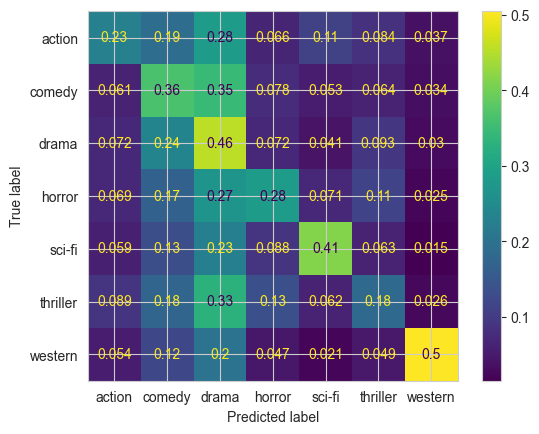

In [164]:
cm = confusion_matrix(df_test['genre'], df_test['frequency_prediction'], labels=labs, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labs)
disp.plot()
plt.show()

In [165]:
# Print the precision and recall, among other metrics
print(metrics.classification_report(df_test['genre'], df_test['frequency_prediction'], digits=3))

              precision    recall  f1-score   support

      action      0.141     0.228     0.174      1314
      comedy      0.386     0.365     0.375      7446
       drama      0.584     0.456     0.512     13612
      horror      0.241     0.284     0.261      2204
      sci-fi      0.164     0.415     0.235       646
    thriller      0.117     0.183     0.143      1590
     western      0.392     0.505     0.441      1032

    accuracy                          0.393     27844
   macro avg      0.289     0.348     0.306     27844
weighted avg      0.440     0.393     0.410     27844



### RNN (LSTM)

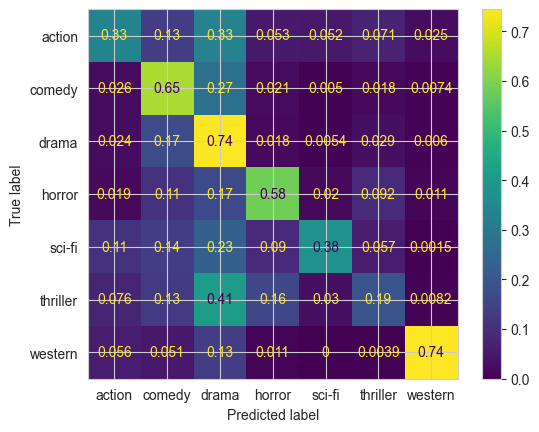

              precision    recall  f1-score   support

      action      0.353     0.335     0.344      1314
      comedy      0.609     0.649     0.628      7446
       drama      0.728     0.745     0.736     13612
      horror      0.618     0.584     0.601      2204
      sci-fi      0.476     0.378     0.421       646
    thriller      0.261     0.193     0.222      1590
     western      0.786     0.743     0.764      1032

    accuracy                          0.647     27844
   macro avg      0.547     0.518     0.531     27844
weighted avg      0.640     0.647     0.642     27844



In [166]:
cm = confusion_matrix(df_test['genre'], df_test['lstm_prediction'], labels=labs, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labs)
disp.plot()
plt.show()

# Print the precision and recall, among other metrics
print(metrics.classification_report(df_test['genre'], df_test['lstm_prediction'], digits=3))

## Bert

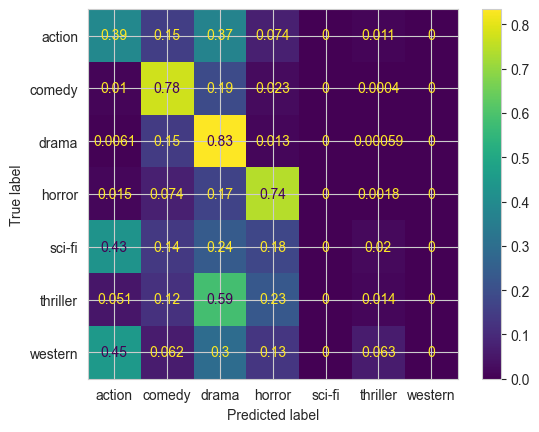

C:\Users\nikit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      action      0.335     0.388     0.360      1314
      comedy      0.682     0.775     0.726      7446
       drama      0.756     0.835     0.793     13612
      horror      0.606     0.741     0.667      2204
      sci-fi      0.000     0.000     0.000       646
    thriller      0.176     0.014     0.027      1590
     western      0.000     0.000     0.000      1032

    accuracy                          0.693     27844
   macro avg      0.365     0.393     0.367     27844
weighted avg      0.626     0.693     0.653     27844



C:\Users\nikit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nikit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [168]:
cm = confusion_matrix(df_test['genre'], df_test['bert_prediction'], labels=labs, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labs)
disp.plot()
plt.show()

# Print the precision and recall, among other metrics
print(metrics.classification_report(df_test['genre'], df_test['bert_prediction'], digits=3))

# Biases

What are potential biases of our model? Some ideas we had were:
* Perhaps the year a movie came out affects classification accuracy? Are older movies classified worse? (Not really.)
* Does length of description affect classification accuracy? (A little.)

## Year

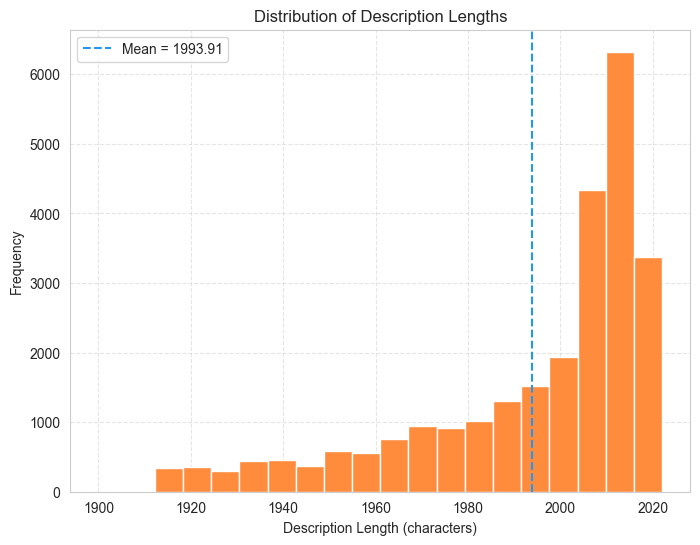

0.25    1982.0
0.50    2005.0
0.75    2013.0
Name: year, dtype: float64

In [169]:
# There are a few movies for which we don't have the year. Remove these.
yrdf = df_test.loc[~(df_test['year'] == 0)]

# Plot a histogram of description lengths.
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(yrdf['year'], bins=20, edgecolor='white', color='#FF8B3D')

# Set chart title and axis labels
ax.set_title('Distribution of Description Lengths')
ax.set_xlabel('Description Length (characters)')
ax.set_ylabel('Frequency')
ax.grid(True, linestyle='--', alpha=0.5)

# Add vertical line for mean value
mean_desc_len = yrdf['year'].mean()
ax.axvline(x=mean_desc_len, color='#2196F3', linestyle='--', label=f'Mean = {mean_desc_len:.2f}')

ax.legend()
plt.show()

yrdf.year.quantile([0.25,0.5,0.75])

In [170]:
yrdf1 = df_test.loc[(1900 < df_test['year']) & (df_test['year'] < 1982)]
yrdf2 = df_test.loc[(2005 > df_test['year']) & (df_test['year'] >= 1982)]
yrdf3 = df_test.loc[(2013 > df_test['year']) & (df_test['year'] >= 2005)]
yrdf4 = df_test.loc[(df_test['year'] >= 2013)]

### TF

In [171]:
f11 = round(f1_score(yrdf1['genre'], yrdf1['frequency_prediction'], average="weighted"),3)
f12 = round(f1_score(yrdf2['genre'], yrdf2['frequency_prediction'], average="weighted"),3)
f13 = round(f1_score(yrdf3['genre'], yrdf3['frequency_prediction'], average="weighted"),3)
f14 = round(f1_score(yrdf4['genre'], yrdf4['frequency_prediction'], average="weighted"),3)
print('Weighted F-1 score for movies that came out:\nbefore 1982:', f11, 
      '\n1982-2005:  ',f12, 
      '\n2005-2013:  ',f13, 
      '\nafter 2013: ',f14)

Weighted F-1 score for movies that came out:
before 1982: 0.449 
1982-2005:   0.421 
2005-2013:   0.42 
after 2013:  0.399


### LSTM

In [172]:
f11 = round(f1_score(yrdf1['genre'], yrdf1['lstm_prediction'], average="weighted"),3)
f12 = round(f1_score(yrdf2['genre'], yrdf2['lstm_prediction'], average="weighted"),3)
f13 = round(f1_score(yrdf3['genre'], yrdf3['lstm_prediction'], average="weighted"),3)
f14 = round(f1_score(yrdf4['genre'], yrdf4['lstm_prediction'], average="weighted"),3)
print('Weighted F-1 score for movies that came out:\nbefore 1982:', f11, 
      '\n1982-2005:  ',f12, 
      '\n2005-2013:  ',f13, 
      '\nafter 2013: ',f14)

Weighted F-1 score for movies that came out:
before 1982: 0.687 
1982-2005:   0.638 
2005-2013:   0.652 
after 2013:  0.63


## Length of Description

In [173]:
df_test['desc_len'] = [len(x) for x in df_test['description']]
a = df_test.desc_len.quantile([0.1,0.2,0.3,.4,.5,.6,.7,.8,.9,1.])
q1, q2, q3, q4, q5, q6, q7, q8, q9, q10 = list(a)

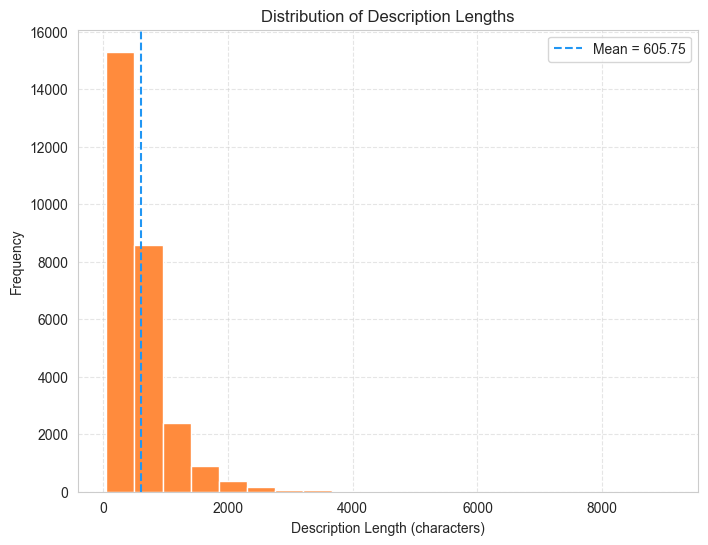

In [174]:
lendf1 = df_test.loc[(df_test['desc_len'] < q1)]
lendf2 = df_test.loc[(q2 > df_test['desc_len']) & (df_test['desc_len'] >= q1)]
lendf3 = df_test.loc[(q3 > df_test['desc_len']) & (df_test['desc_len'] >= q2)]
lendf4 = df_test.loc[(q4 > df_test['desc_len']) & (df_test['desc_len'] >= q3)]
lendf5 = df_test.loc[(q5 > df_test['desc_len']) & (df_test['desc_len'] >= q4)]
lendf6 = df_test.loc[(q6 > df_test['desc_len']) & (df_test['desc_len'] >= q5)]
lendf7 = df_test.loc[(q7 > df_test['desc_len']) & (df_test['desc_len'] >= q6)]
lendf8 = df_test.loc[(q8 > df_test['desc_len']) & (df_test['desc_len'] >= q7)]
lendf9 = df_test.loc[(q9 > df_test['desc_len']) & (df_test['desc_len'] >= q8)]
lendf10 = df_test.loc[(df_test['desc_len'] >= q9)]


# Plot a histogram of description lengths.
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(df_test['desc_len'], bins=20, edgecolor='white', color='#FF8B3D')

# Set chart title and axis labels
ax.set_title('Distribution of Description Lengths')
ax.set_xlabel('Description Length (characters)')
ax.set_ylabel('Frequency')
ax.grid(True, linestyle='--', alpha=0.5)

# Add vertical line for mean value
mean_desc_len = df_test['desc_len'].mean()
ax.axvline(x=mean_desc_len, color='#2196F3', linestyle='--', label=f'Mean = {mean_desc_len:.2f}')

ax.legend()
plt.show()

### TF

In [175]:
bf11 = round(f1_score(lendf1['genre'], lendf1['frequency_prediction'], average="weighted"),3)
bf12 = round(f1_score(lendf2['genre'], lendf2['frequency_prediction'], average="weighted"),3)
bf13 = round(f1_score(lendf3['genre'], lendf3['frequency_prediction'], average="weighted"),3)
bf14 = round(f1_score(lendf4['genre'], lendf4['frequency_prediction'], average="weighted"),3)
bf15 = round(f1_score(lendf5['genre'], lendf5['frequency_prediction'], average="weighted"),3)
bf16 = round(f1_score(lendf6['genre'], lendf6['frequency_prediction'], average="weighted"),3)
bf17 = round(f1_score(lendf7['genre'], lendf7['frequency_prediction'], average="weighted"),3)
bf18 = round(f1_score(lendf8['genre'], lendf8['frequency_prediction'], average="weighted"),3)
bf19 = round(f1_score(lendf9['genre'], lendf9['frequency_prediction'], average="weighted"),3)
bf110 = round(f1_score(lendf10['genre'], lendf10['frequency_prediction'], average="weighted"),3)
base_f1_by_len = [bf11, bf12, bf13, bf14, bf15, bf16, bf17, bf18, bf19, bf110]

### LSTM

In [176]:
lf11 = round(f1_score(lendf1['genre'], lendf1['lstm_prediction'], average="weighted"),3)
lf12 = round(f1_score(lendf2['genre'], lendf2['lstm_prediction'], average="weighted"),3)
lf13 = round(f1_score(lendf3['genre'], lendf3['lstm_prediction'], average="weighted"),3)
lf14 = round(f1_score(lendf4['genre'], lendf4['lstm_prediction'], average="weighted"),3)
lf15 = round(f1_score(lendf5['genre'], lendf5['lstm_prediction'], average="weighted"),3)
lf16 = round(f1_score(lendf6['genre'], lendf6['lstm_prediction'], average="weighted"),3)
lf17 = round(f1_score(lendf7['genre'], lendf7['lstm_prediction'], average="weighted"),3)
lf18 = round(f1_score(lendf8['genre'], lendf8['lstm_prediction'], average="weighted"),3)
lf19 = round(f1_score(lendf9['genre'], lendf9['lstm_prediction'], average="weighted"),3)
lf110 = round(f1_score(lendf10['genre'], lendf10['lstm_prediction'], average="weighted"),3)
lstm_f1_by_len = [lf11, lf12, lf13, lf14, lf15, lf16, lf17, lf18, lf19, lf110]

In [181]:
br11 = round(f1_score(lendf1['genre'], lendf1['bert_prediction'], average="weighted"),3)
br12 = round(f1_score(lendf2['genre'], lendf2['bert_prediction'], average="weighted"),3)
br13 = round(f1_score(lendf3['genre'], lendf3['bert_prediction'], average="weighted"),3)
br14 = round(f1_score(lendf4['genre'], lendf4['bert_prediction'], average="weighted"),3)
br15 = round(f1_score(lendf5['genre'], lendf5['bert_prediction'], average="weighted"),3)
br16 = round(f1_score(lendf6['genre'], lendf6['bert_prediction'], average="weighted"),3)
br17 = round(f1_score(lendf7['genre'], lendf7['bert_prediction'], average="weighted"),3)
br18 = round(f1_score(lendf8['genre'], lendf8['bert_prediction'], average="weighted"),3)
br19 = round(f1_score(lendf9['genre'], lendf9['bert_prediction'], average="weighted"),3)
br110 = round(f1_score(lendf10['genre'], lendf10['bert_prediction'], average="weighted"),3)
bert_f1_by_len = [br11, br12, br13, br14, br15, br16, br17, br18, br19, br110]

### GRU

In [177]:
f11 = round(f1_score(lendf1['genre'], lendf1['gru_prediction'], average="weighted"),3)
f12 = round(f1_score(lendf2['genre'], lendf2['gru_prediction'], average="weighted"),3)
f13 = round(f1_score(lendf3['genre'], lendf3['gru_prediction'], average="weighted"),3)
f14 = round(f1_score(lendf4['genre'], lendf4['gru_prediction'], average="weighted"),3)
print('Weighted F-1 score by length of description (# of characters):\n0-221:   ', f11, 
      '\n250-316: ',f12, 
      '\n316-448: ',f13, 
      '\n448-2500:',f14)

Weighted F-1 score by length of description (# of characters):
0-221:    0.589 
250-316:  0.616 
316-448:  0.608 
448-2500: 0.626


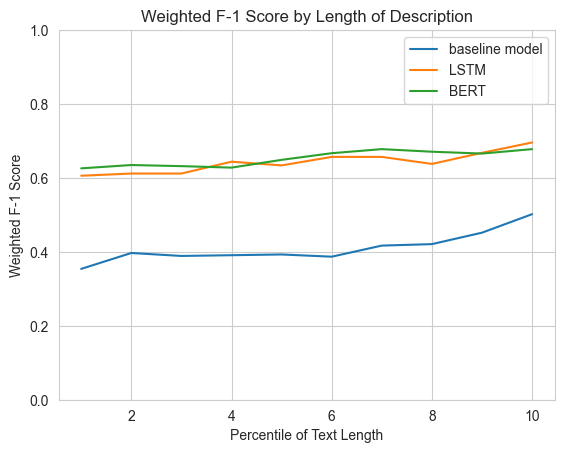

In [182]:
import matplotlib.pyplot as plt

# Sample data
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
y1 = [5, 4, 6, 8, 7]
y2 = [2, 4, 3, 1, 5]
y3 = [7, 8, 6, 4, 5]

# Line graphs
plt.plot(x, base_f1_by_len, label='baseline model')
plt.plot(x, lstm_f1_by_len, label='LSTM')
plt.plot(x, bert_f1_by_len, label='BERT')


# Set chart title and axis labels
plt.title('Weighted F-1 Score by Length of Description')
plt.xlabel('Percentile of Text Length')
plt.ylabel('Weighted F-1 Score')
plt.ylim(0, 1.0)

# Show legend and grid
plt.legend()
plt.grid(True)

# Display the chart
plt.show()
